In [46]:
from pathlib import Path
import shutil
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [37]:
workdir = Path('/home/jphacks/LipNet-JP/')
youtube_id = '1'
txtpath = workdir / 'data/align' / 'output1.align'
aligned_lm_path = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned.csv'.format(youtube_id))
lm_path = Path('/home/jphacks/LipNet-JP/data/processed/{0}/{0}.csv'.format(youtube_id))
croppeddir = Path('/home/jphacks/LipNet-JP/data/processed2/{0}/{0}_aligned_aligned_cropped'.format(youtube_id))
assert croppeddir.exists()

In [26]:
with open(txtpath, 'r') as f:
    txt = json.load(f)

In [27]:
len(txt)

450

In [28]:
len(txt[0])

3

In [29]:
start0 = 0
end0 = 0
for w in txt[0]:
    start = w['start']
    end = w['end']
    print(start, end)
    print(start * 1_000 * 30, end * 1_000 * 30)
    break

0.24 0.4
7200.0 12000.0


# データの照らし合わせ

## txt情報の単位をフレーム番号と照らし合わせる

In [30]:
aligned_lm_df = pd.read_csv(str(aligned_lm_path))
aligned_lm_df.head(3)

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.0,0.98,1,0.077917,0.293945,-0.952641,-0.316540,0.281786,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,2,0,0.0,0.98,1,0.077251,0.272675,-0.959000,-0.317211,0.262823,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,3,0,0.0,0.98,1,0.078179,0.285228,-0.955266,-0.303922,0.250068,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
# Get timestamp from frame
aligned_lm_df[' timestamp'] = (aligned_lm_df['frame'] - 1) * (1/30)
aligned_lm_df.head(3)

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000000,0.98,1,0.077917,0.293945,-0.952641,-0.316540,0.281786,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,2,0,0.033333,0.98,1,0.077251,0.272675,-0.959000,-0.317211,0.262823,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,3,0,0.066667,0.98,1,0.078179,0.285228,-0.955266,-0.303922,0.250068,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


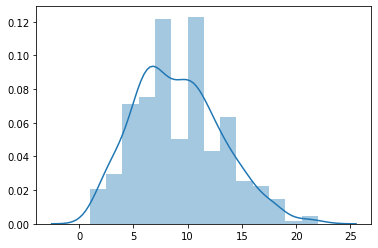

In [32]:
distribution = []
for word in txt:
    start0 = 10000000
    end0 = 0
    for w in word:
        start = w['start']
        end = w['end']
#         print(start, end)
        start0 = min(start0, start)
        end0 = max(end0, end)
#     print(start0, end0)

    video = aligned_lm_df[(aligned_lm_df[' timestamp'] > start0) & (aligned_lm_df[' timestamp'] < end0)]
    # TODO: exclude rotated faces
    distribution.append(len(video))
    
sns.distplot(distribution)

In [33]:
aligned_lm_df[(aligned_lm_df[' timestamp'] > start0) & (aligned_lm_df[' timestamp'] < end0)]

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
8821,8822,0,294.033333,0.98,1,0.140809,0.326962,-0.934489,-0.198623,0.298263,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
8822,8823,0,294.066667,0.98,1,0.150457,0.322335,-0.934592,-0.191991,0.304547,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
8823,8824,0,294.100000,0.98,1,0.146324,0.311414,-0.938941,-0.193710,0.298439,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8824,8825,0,294.133333,0.98,1,0.152923,0.322806,-0.934029,-0.195477,0.285684,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8825,8826,0,294.166667,0.98,1,0.202950,0.266456,-0.942238,-0.193643,0.281975,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
pd.read_csv(str(lm_path))

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.000,0.98,1,0.122208,0.440269,-0.889510,-0.151685,0.462555,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,2,0,0.033,0.98,1,0.136644,0.429325,-0.892753,-0.144216,0.462415,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,3,0,0.067,0.98,1,0.128733,0.440351,-0.888549,-0.158765,0.462140,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,4,0,0.100,0.98,1,0.128985,0.442171,-0.887608,-0.165051,0.458954,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,5,0,0.133,0.98,1,0.118151,0.449952,-0.885203,-0.169928,0.465124,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8833,8834,0,294.433,0.88,1,0.388000,0.174935,-0.904905,0.262501,0.190831,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8834,8835,0,294.467,0.88,1,0.400772,0.192949,-0.895630,0.285169,0.210322,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8835,8836,0,294.500,0.88,1,0.397597,0.211370,-0.892882,0.297737,0.230469,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8836,8837,0,294.533,0.88,1,0.392809,0.247265,-0.885754,0.296845,0.268548,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## main.pyが欲しい形式に保存し直す

original
```
video_path = 'lip/'
train_list = 'data/unseen_train.txt'
val_list = 'data/unseen_val.txt'
anno_path = 'GRID_align_txt'

s14/video/mpg_6000/lwwy5n
{video_id}/video/mpg_6000/{sentence_id}
GRID_align_txt/s1/align/{sentence_id}.align
```

ours
```
video_path = 'data/lip_video/'
train_list = 'data/jp_train.txt'
val_list = 'data/jp_val.txt'
anno_path = 'data/align_txt'

s14/video/mpg_6000/lwwy5n
{video_id}/video/mpg_6000/{sentence_id}
GRID_align_txt/s1/align/{sentence_id}.align
```

In [35]:
datadir = Path('/home/jphacks/LipNet-JP/data')
videodir = datadir / 'lip_video'
txtdir = datadir / 'align_txt'

### センテンスに対して実行

動画を保存

txtを追記

In [51]:
spk = 's1'

train_rate = 0.8
all_len = len(txt)
train_f = open(str(datadir / 'jp_train.txt'), 'w')
val_f = open(str(datadir / 'jp_val.txt'), 'w')
for idx, word in tqdm(enumerate(txt)):
    start0 = 10000000
    end0 = 0
    for w in word:
        start = w['start']
        end = w['end']
        start0 = min(start0, start)
        end0 = max(end0, end)

    video = aligned_lm_df[(aligned_lm_df[' timestamp'] > start0) & (aligned_lm_df[' timestamp'] < end0)]
    # TODO: exclude rotated faces
#     print(video.frame.values)
#     print(word)
    
    frames_dir = videodir / spk / 'video/mpg_6000' / '{:06d}'.format(idx)
    frames_dir.mkdir(parents=True, exist_ok=True)
#     print(videodir / spk / 'video/mpg_6000' / '{:06d}'.format(idx))
#     print(txtdir / spk / 'align' / '{:06d}.align'.format(idx))
    
    # Copy video frames
    for frame in video.frame.values:
        frame_path = croppeddir / 'frame_det_00_{:06d}.bmp'.format(frame)
        assert frame_path.exists()
        frame_outpath = frames_dir / 'frame_det_00_{:06d}.bmp'.format(frame)
        shutil.copy(str(frame_path), str(frame_outpath))   
        
        f = train_f if (idx < all_len * train_rate) else val_f
        f.write('{}\n'.format('{}/video/mpg_6000/{:06d}'.format(spk, idx)))
    # Write txt file
    (txtdir / spk / 'align').mkdir(parents=True, exist_ok=True)
    with open(str(txtdir / spk / 'align' / '{:06d}.align'.format(idx)), 'w') as f:
        for w in word:
            start = w['start']
            end = w['end']
            start0 = min(start0, start)
            end0 = max(end0, end)
            f.write('{} {} {}\n'.format(start, end, w['word']))


450it [00:02, 159.61it/s]
